<b>
<p>
<center>
<font size="5">
Machine Learning I
</font>
</center>
</p>

<p>
<center>
<font size="4">
Final Project
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size="3">
Tejas Rawal
</font>
</center>
</p>
</b>

# Using satellite imagery to understand the Amazon from space

# Introduction

# Experiment

## Notebook setup

First, we will mount Google Drive and define the location of our working directory within the Drive.

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# setup path to project folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/Final-Project/'

Mounted at /content/drive


Set the warnings filter to `ignore` so warnings are not displayed in the code output

In [ ]:
import warnings

warnings.filterwarnings('ignore')

Import graphing libraries `matplotlib` and `plotly`.

In [ ]:
from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

Configuring random seed on `numpy` and `tenserflow` libraries

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np

random_seed = 42

tf.random.set_seed(random_seed)

np.random.seed(random_seed)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Data Preprocessing

### Loading the training data

In [ ]:
import os

directory = os.path.dirname(abspath_curr + '/data/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
import pandas as pd

df_train = pd.read_csv(abspath_curr + 'data/train_v2.csv')

## Exploratory Data Analysis

#### Image Tags

In [ ]:
df_train.shape

(40479, 2)

The image tags CSV file has 40,479 rows, with each row representing a satellite image file along with its associated tags. We can look at the first 10 rows of the data to see what values the columns contain.

In [ ]:
df_train.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


The first column, `image_name`, represents the name of the satellite image chip. The second column, `tags`, is our target column which represents all the labels present in that particular image.

#### Visualizing Tag Distribution

First, we need to extract all tag values from the `tags` columns and count how many of each exist within the data.

In [ ]:
from collections import Counter
from itertools import chain

# split tags by a single space
tags_list = df_train.tags.str.split(" ")

# creates an iterable object composed of the flattened tags_list
all_tags_iter = chain(*tags_list)

# count instances of each tag in the all_tags list and store in a dictionary
# tag names are stored as keys and their counts are stored as values
counter_tags = Counter(all_tags_iter)
counter_tags



Counter({'haze': 2697,
         'primary': 37513,
         'agriculture': 12315,
         'clear': 28431,
         'water': 7411,
         'habitation': 3660,
         'road': 8071,
         'cultivation': 4547,
         'slash_burn': 209,
         'cloudy': 2089,
         'partly_cloudy': 7261,
         'conventional_mine': 100,
         'bare_ground': 862,
         'artisinal_mine': 339,
         'blooming': 332,
         'selective_logging': 340,
         'blow_down': 101})

Now that we have a dictionary of the counts for each tag, we can visualize the distribution using a bar graph.

In [ ]:
# create dataframe from tags counter
df_tags = pd.DataFrame({
    "Tag": counter_tags.keys(),
    "Count": counter_tags.values()}
).sort_values("Count")

fig = px.bar(df_tags, x="Count", y="Tag", orientation="h",
             color="Count",
)
fig.update_layout(title="Tag distribution")
fig.show()

We can see that the distribution of tags across images is significantly skewed. Tags such as `conventional_mine`, `blow_down`, and `slash_burn` barely show up in the data. This could lead to bias in our model unless it is addressed.

#### Visualizing Images by Tag

Now that we understand the distribution of our tags, let's observe them individually using the training images provided. There are a total of 17 tags, and each image is mapped to a list of tags. We can extract an image per tag and visualize them using the openCV python library.

In [ ]:
import cv2

all_tags = list(counter_tags.keys())
N_tags = len(all_tags)

fig, axes = plt.subplots(4, (N_tags // 4) + 1, figsize=(20, 20))

for idx, tag in enumerate(all_tags):
  # get image name based on a matching tag
  matching_tag_rows = df_train.query(f"tags.str.contains('{tag}')")
  image_name = matching_tag_rows.image_name.sample(n=1, random_state=random_seed).values[0]
  filename = image_name + ".jpg"
  filepath = os.path.join(abspath_curr, "data/train-jpg/", filename)

  # read image file
  img = cv2.imread(filepath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # add image to graph
  idx_col = idx // 4
  idx_row = idx % 4
  axes[idx_row][idx_col].set_title(tag)
  axes[idx_row][idx_col].imshow(img)

# remove unused subplot areas
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

# configure spacing between subplots
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Labels such as `water` and `road` look very similar and will make it difficult for the model to differentiate. There's also strong correlation between `habitation` and `road`, `cultivation` and `agriculture`, and the 2 mine tags.

## Initializing and splitting the data

### Formatting training data

In [ ]:
# Initialize empty lists to store the training images and their labels
X_train = []
y_train = []

# set the default image size
input_size = (128, 128)

# Create a map for the unique tags in the dataset
tag_map = {tag: idx for idx, tag in enumerate(counter_tags.keys())}

# reduce size of training set due to computation limitations
df_train = df_train[:5365]

# Loop through the training DataFrame
for image_name, tags in df_train.values:
    # Read the image file
    img = cv2.imread(os.path.join(abspath_curr, "data/train-jpg/", f"{image_name}.jpg"))

    # Initialize an array of zeros for the targets
    targets = np.zeros(N_tags)

    # Loop through the tags for the current image
    for tag in tags.split(' '):
        # Set the corresponding target value to 1
        targets[tag_map[tag]] = 1

    # Append the image and its labels to the appropriate lists
    X_train.append(cv2.resize(img, input_size))
    y_train.append(targets)

(5365, 2)


Convert the training lists into numpy arrays and designate the value type. For the images, we can normalize the pixel values by dividing by `255` (the max pixel value).

In [ ]:
X_train = np.array(X_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

### Splitting the data into training and validation sets

Here, we split the training data in training and validation sets. 70% of the data is designated for training, and the remaining 30% for validation.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.3,
                                                  shuffle=True,
                                                  random_state=random_seed)

Let's inspect the newly split dataframes.

In [ ]:
print("Training features shape:", X_train.shape)
print("Training target shape:", y_train.shape)

Training features shape: (3755, 128, 128, 3)
Training target shape: (3755, 17)


In [ ]:
print("Validation features shape:", X_val.shape)
print("Validation target shape:", y_val.shape)

Validation features shape: (1610, 128, 128, 3)
Validation target shape: (1610, 17)


## Training

### Helper methods

The competition evaluates submissions based on the F-beta score metric. Unfortunately, the F-beta metric was removed in Keras 2.0 so we'll have to create one from scratch.

Implemented thanks to https://www.kaggle.com/code/bolusunday/notebook1a2829773a

In [ ]:
def fbeta(y_true, y_pred, beta = 2, epsilon = 1e-4):
    beta_squared = beta**2

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.2)), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    return ((1 + beta_squared) * precision * recall) / (beta_squared * precision + recall + epsilon)


In [ ]:
def multi_label_acc(y_true, y_pred, epsilon = 1e-4):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.2)), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp

    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32)
                       * tf.cast(tf.logical_not(y_pred), tf.float32), axis = 1)

    return (tp + tn)/(tp + tn + fp + fn + epsilon)

### Constructing a custom model

#### Building the model

We start by building our own CNN using layers from the `keras` library. We also create a directory to save the weights of the best model.

In [ ]:
directory = os.path.dirname(abspath_curr + 'result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# import necessary layers
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D

We are building a sequential model, including convolution, max pooling, dropout, and dense layers. The input layer uses batch normalization to normalize the input data.

In [ ]:
custom_model = Sequential([
  # add BatchNormalization as first layer to normalize input data
  BatchNormalization(input_shape=(128, 128, 3)),

  # convolution layers with max pooling layer
  Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
  Conv2D(32, kernel_size=(3, 3), activation='relu'),
  MaxPool2D(pool_size=(2, 2)),
  # Dropout layers added to prevent overfitting.
  Dropout(0.2),

  # add more convolution layers for feature extraction
  Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
  Conv2D(64, kernel_size=(3, 3), activation='relu'),
  MaxPool2D(pool_size=(2, 2)),
  Dropout(0.2),

  # another round of convolution and pooling layers
  Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
  Conv2D(128, kernel_size=(3, 3), activation='relu'),
  Conv2D(128, kernel_size=(3, 3), activation='relu'),
  MaxPool2D(pool_size=(2, 2)),
  Dropout(0.2),

  # another round of convolution and pooling layers
  Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
  Conv2D(256, kernel_size=(3, 3), activation='relu'),
  Conv2D(256, kernel_size=(3, 3), activation='relu'),
  MaxPool2D(pool_size=(2, 2)),
  Dropout(0.2),

  # Flatten layer to convert the 2D feature maps into a 1D feature vector
  Flatten(),

  # fully connected dense layers and output layer
  Dense(512, activation='relu'),
  Dropout(0.4),
  Dense(N_tags, activation='sigmoid')
])

Let's take a look at the structure of our model.

In [ ]:
custom_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 63, 63, 64)       

We also plot the model architecture and save it as an image

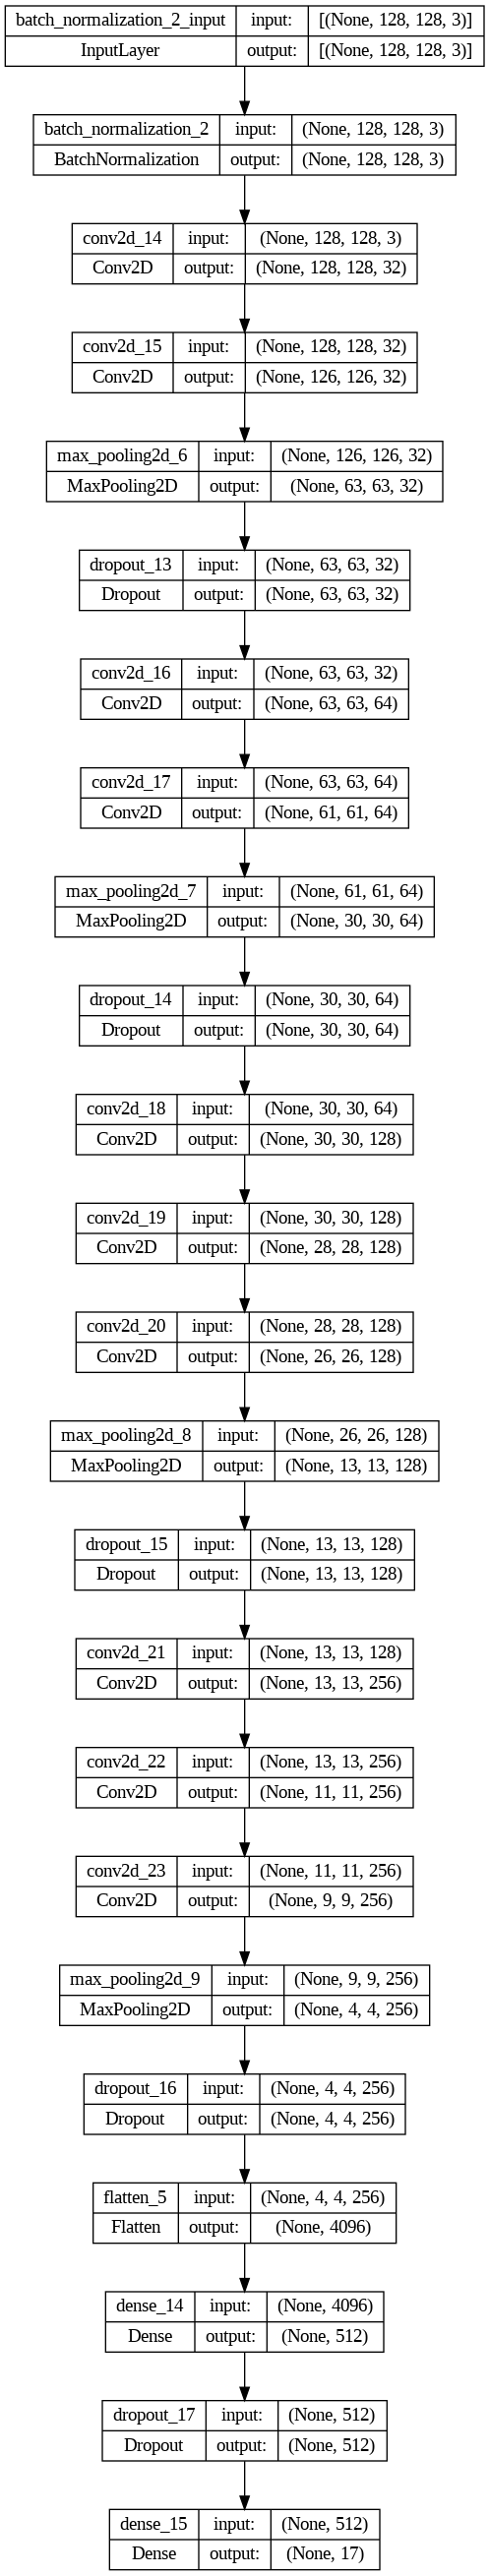

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(custom_model,
           to_file=abspath_curr + 'result/model/custom_model_plot.png',
           show_shapes=True,
           show_layer_names=True)

#### Adding callbacks

* `ModelCheckpoint` saves the model output to the specified file.
* `EarlyStopping` stops training early if the validation loss does not improve after 2 epochs and restores model weigths to those of the best epoch.
* `ReduceLROnPlateau` reduces the model's learning rate by a factor of 0.5 when the current learning rate fails to improve the validation loss after 2 epoch

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# ModelCheckpoint
model_checkpoint_cb = ModelCheckpoint(filepath=abspath_curr + 'result/model/custom_model.h5',
                                      save_best_only=True,
                                      save_weights_only=True)

# EarlyStopping
early_stopping_cb = EarlyStopping(patience=2, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = ReduceLROnPlateau(factor=0.5, patience=2)

#### Compiling the model

* apply Adaptive Moment Estimation (Adam) for
optimization, with an initial learning rate of `0.001`
* use `binary_crossentropy` as the loss function
* output multi-label accuracy and f-beta metrics of the model


In [ ]:
from keras.optimizers import Adam

custom_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[fbeta, multi_label_acc])

#### Train, validate, and save the best model

After compilation, we can train the model on our training dataset and validate using the validation dataset.

* trained over 10 epochs
* batch size of 32

In [ ]:
# Training the model on the training data for 10 epoch with a batch size of 128, and validating the model on the validation data
history = custom_model.fit(X_train, y_train,
                      batch_size=16,
                      epochs=10,
                      verbose=1,
                      validation_data=(X_val, y_val),
                      callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/10
235/235 [==============================] - 7s 24ms/step - loss: 0.2756 - fbeta: 0.6942 - multi_label_acc: 0.8063 - val_loss: 0.2362 - val_fbeta: 0.7342 - val_multi_label_acc: 0.8686 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 5s 21ms/step - loss: 0.2269 - fbeta: 0.7532 - multi_label_acc: 0.8496 - val_loss: 0.2135 - val_fbeta: 0.7777 - val_multi_label_acc: 0.8446 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 4s 18ms/step - loss: 0.2192 - fbeta: 0.7700 - multi_label_acc: 0.8540 - val_loss: 0.2222 - val_fbeta: 0.7668 - val_multi_label_acc: 0.8380 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 4s 18ms/step - loss: 0.2161 - fbeta: 0.7757 - multi_label_acc: 0.8566 - val_loss: 0.2172 - val_fbeta: 0.7640 - val_multi_label_acc: 0.8627 - lr: 0.0010


#### Visualizing model loss, accuracy, and F-score

In [ ]:
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
  os.makedirs(directory)

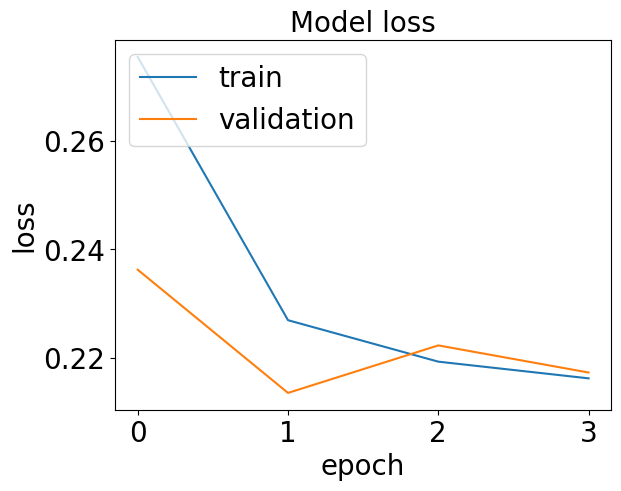

In [ ]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Adding title, y-label and x-label to the plot
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

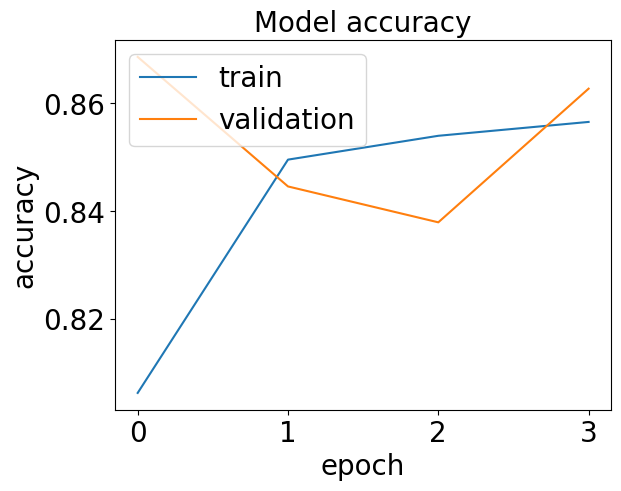

In [ ]:
# Plotting the training and validation accuracy
plt.plot(history.history['multi_label_acc'])
plt.plot(history.history['val_multi_label_acc'])

# Adding title, y-label and x-label to the plot
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

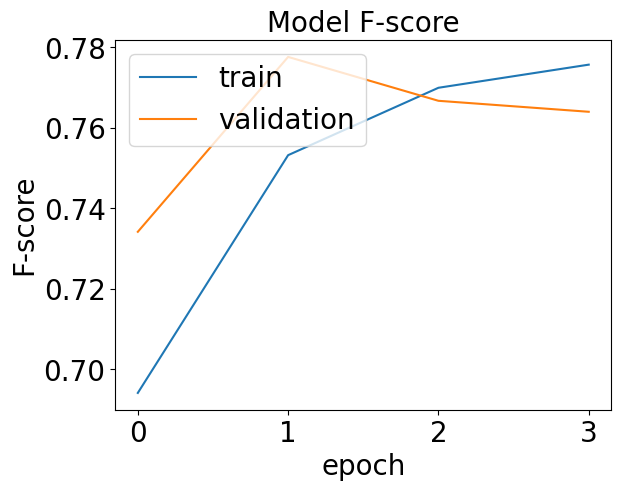

In [ ]:
# Plotting the training and validation F-scores
plt.plot(history.history['fbeta'])
plt.plot(history.history['val_fbeta'])

# Adding title, y-label and x-label to the plot
plt.title('Model F-score')
plt.ylabel('F-score')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

### Using ResNet50 with transfer learning

To try and improve upon our previous performance, we will utilize the pre-trained ResNet50 model trained on the ImageNet dataset.

In [ ]:
from keras.applications import ResNet50

pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


For the first iteration, we will freeze all pre-trained layers in the model so that their weights are not modified during training.

In [ ]:
for layer in pretrained_model.layers:
  layer.trainable = False

#### Constructing the model

We can now add some layers to the top of the
pretrained model.

In [ ]:
from keras.layers import GlobalAveragePooling2D

model = Sequential([
  pretrained_model,
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(0.4),
  Dense(N_tags, activation='sigmoid')
])

Let's take a look at the model summary below.

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_16 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 17)                8721      
                                                                 
Total params: 40,374,161
Trainable params: 16,786,449
Non-trainable params: 23,587,712
_________________________________________________________________


And plot the model architecture.

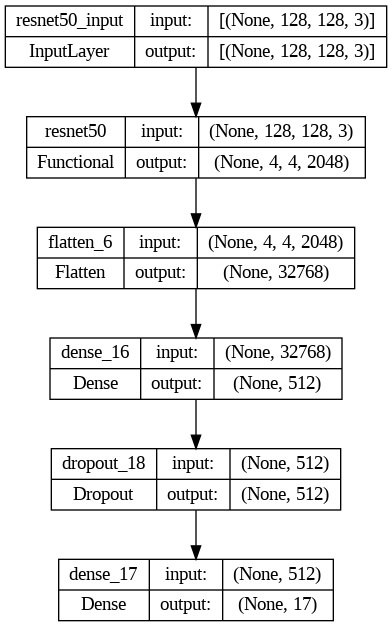

In [ ]:
plot_model(model,
           to_file=abspath_curr + 'result/model/resnet_model_frozen_plot.png',
           show_shapes=True,
           show_layer_names=True)

We need to modify the `ModelCheckpoint` callback so the model weights are saved in a different file than the previous one. We also modify the `ReduceLROnPlateau` here to reduce the `factor` parameter.

In [ ]:
model_checkpoint_cb = ModelCheckpoint(filepath=abspath_curr + 'result/model/pretrained_model_frozen.h5',
                                      save_best_only=True,
                                      save_weights_only=True)

reduce_lr_on_plateau_cb = ReduceLROnPlateau(factor=0.1, patience=2)

#### Compiling the model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[fbeta, multi_label_acc])

#### Train, validate, and save best model

In [ ]:
history = model.fit(X_train, y_train, batch_size=16,
                          epochs=10, verbose=1,
                          validation_data=(X_val, y_val),
                          callbacks=[model_checkpoint_cb,
                                     early_stopping_cb,
                                     reduce_lr_on_plateau_cb])

Epoch 1/10
235/235 [==============================] - 14s 34ms/step - loss: 0.2900 - fbeta: 0.6593 - multi_label_acc: 0.8144 - val_loss: 0.2575 - val_fbeta: 0.6985 - val_multi_label_acc: 0.8396 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 6s 25ms/step - loss: 0.2638 - fbeta: 0.6805 - multi_label_acc: 0.8254 - val_loss: 0.2566 - val_fbeta: 0.6858 - val_multi_label_acc: 0.7687 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 5s 23ms/step - loss: 0.2613 - fbeta: 0.6899 - multi_label_acc: 0.8281 - val_loss: 0.2546 - val_fbeta: 0.7150 - val_multi_label_acc: 0.8614 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 6s 25ms/step - loss: 0.2571 - fbeta: 0.6965 - multi_label_acc: 0.8336 - val_loss: 0.2532 - val_fbeta: 0.7193 - val_multi_label_acc: 0.8218 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 6s 25ms/step - loss: 0.2593 - fbeta: 0.6920 - multi_label_acc: 0.8258 - val_loss: 0.2523 - val_fbeta: 0.7166 - val_multi_

#### Visualizing model loss, accuracy, and F-score

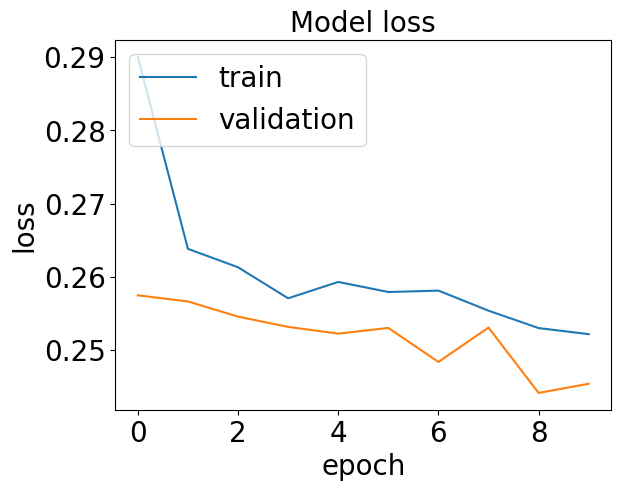

In [ ]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Adding title, y-label and x-label to the plot
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

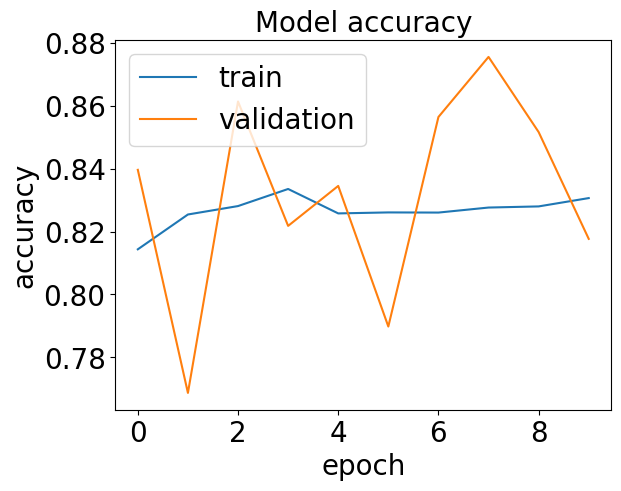

In [ ]:
# Plotting the training and validation accuracy
plt.plot(history.history['multi_label_acc'])
plt.plot(history.history['val_multi_label_acc'])

# Adding title, y-label and x-label to the plot
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

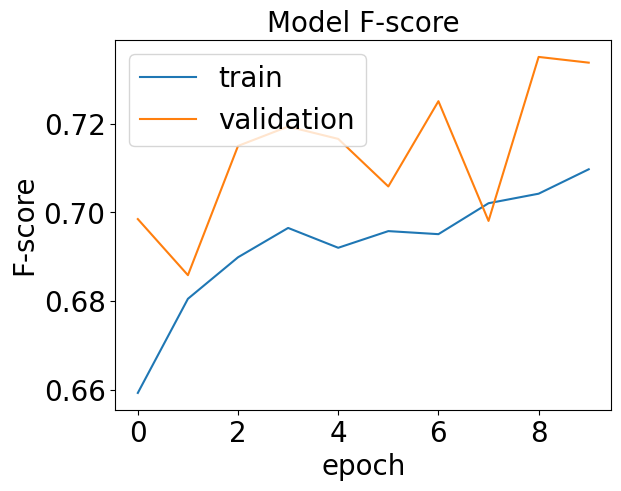

In [ ]:
# Plotting the training and validation F-scores
plt.plot(history.history['fbeta'])
plt.plot(history.history['val_fbeta'])

# Adding title, y-label and x-label to the plot
plt.title('Model F-score')
plt.ylabel('F-score')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

The frozen ResNet model architecture shows a slight degradration in performance when compared to the custom model we built earlier. This is pretty fascinating considering we only added a few top layers to the frozen ResNet50 model. Perhaps tweaking the model further will help improve the results.

### Unfreezing layers of ResNet50

For further evaluation, lets unfreeze all layers of the pretrained ResNet50 model so that its weights can be updated during training.

In [ ]:
for layer in pretrained_model.layers:
  layer.trainable = True

After this step, we need to recompile the model to save these settings.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[fbeta, multi_label_acc])

In [ ]:
model_checkpoint_cb = ModelCheckpoint(filepath=abspath_curr + 'result/model/pretrained_model_unfrozen.h5',
                                      save_best_only=True,
                                      save_weights_only=True)

reduce_lr_on_plateau_cb = ReduceLROnPlateau(factor=0.4, patience=2)

And now we can train again.

In [ ]:
history = model.fit(X_train, y_train, batch_size=16,
                          epochs=10, verbose=1,
                          validation_data=(X_val, y_val),
                          callbacks=[model_checkpoint_cb,
                                     early_stopping_cb,
                                     reduce_lr_on_plateau_cb])

Epoch 1/10
235/235 [==============================] - 20s 56ms/step - loss: 0.2356 - fbeta: 0.7869 - multi_label_acc: 0.8754 - val_loss: 0.3074 - val_fbeta: 0.6501 - val_multi_label_acc: 0.6759 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 10s 43ms/step - loss: 0.1919 - fbeta: 0.8183 - multi_label_acc: 0.8894 - val_loss: 0.3169 - val_fbeta: 0.6527 - val_multi_label_acc: 0.6639 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 10s 43ms/step - loss: 0.1834 - fbeta: 0.8264 - multi_label_acc: 0.8930 - val_loss: 1.7717 - val_fbeta: 0.4307 - val_multi_label_acc: 0.7693 - lr: 0.0010


#### Visualizing model loss, accuracy, and F-score

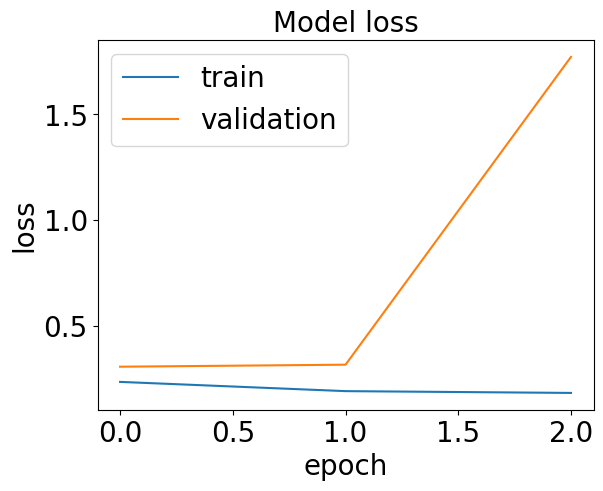

In [ ]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Adding title, y-label and x-label to the plot
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

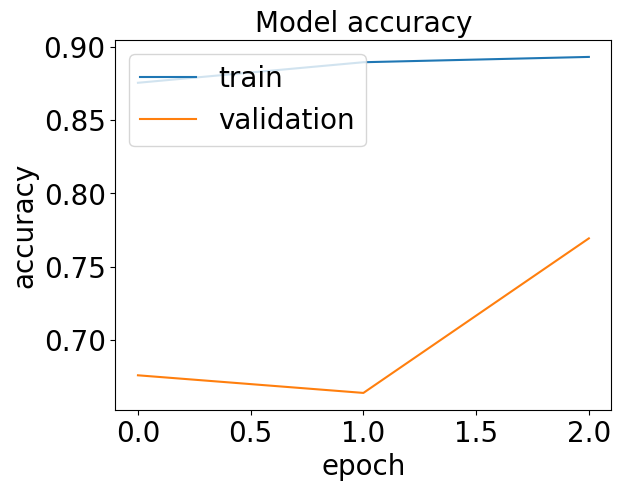

In [ ]:
# Plotting the training and validation accuracy
plt.plot(history.history['multi_label_acc'])
plt.plot(history.history['val_multi_label_acc'])

# Adding title, y-label and x-label to the plot
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

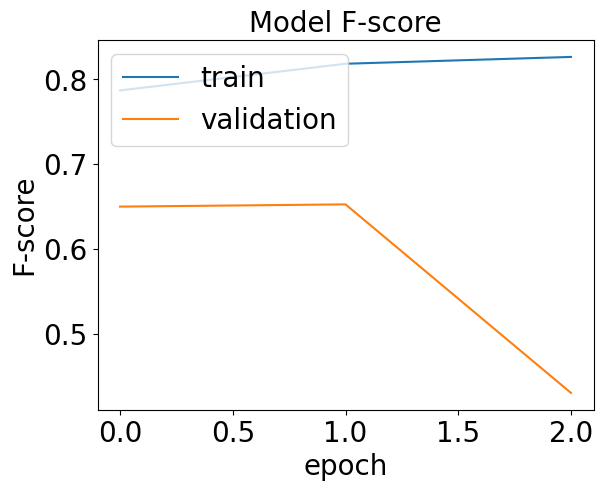

In [ ]:
# Plotting the training and validation F-scores
plt.plot(history.history['fbeta'])
plt.plot(history.history['val_fbeta'])

# Adding title, y-label and x-label to the plot
plt.title('Model F-score')
plt.ylabel('F-score')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

Looks like there might have been some overfitting happening here. The results looked better than the other 2 models for the first 2 epochs, but suddenly took a turn for the worse.

Rather than unfreezing all layers in the ResNet50 pretrained model, we can try to unfreeze only the last 2.

In [ ]:
for layer in pretrained_model.layers:
  layer.trainable = False

for layer in pretrained_model.layers[-2:]:
  layer.trainable = True

# recompile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[fbeta, multi_label_acc])


# define new location to save weights
model_checkpoint_cb = ModelCheckpoint(filepath=abspath_curr + 'result/model/pretrained_model_last_two.h5',
                                      save_best_only=True,
                                      save_weights_only=True)

# fit new model
history = model.fit(X_train, y_train, batch_size=16,
                          epochs=10, verbose=1,
                          validation_data=(X_val, y_val),
                          callbacks=[model_checkpoint_cb,
                                     early_stopping_cb,
                                     reduce_lr_on_plateau_cb])

Epoch 1/10
235/235 [==============================] - 11s 34ms/step - loss: 0.2619 - fbeta: 0.6765 - multi_label_acc: 0.8314 - val_loss: 0.2593 - val_fbeta: 0.6812 - val_multi_label_acc: 0.8422 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 5s 23ms/step - loss: 0.2576 - fbeta: 0.6829 - multi_label_acc: 0.8343 - val_loss: 0.2552 - val_fbeta: 0.6953 - val_multi_label_acc: 0.8184 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 6s 24ms/step - loss: 0.2534 - fbeta: 0.6945 - multi_label_acc: 0.8437 - val_loss: 0.2518 - val_fbeta: 0.7094 - val_multi_label_acc: 0.8250 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 6s 25ms/step - loss: 0.2500 - fbeta: 0.6995 - multi_label_acc: 0.8455 - val_loss: 0.2491 - val_fbeta: 0.7040 - val_multi_label_acc: 0.8595 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 5s 23ms/step - loss: 0.2475 - fbeta: 0.7079 - multi_label_acc: 0.8479 - val_loss: 0.2463 - val_fbeta: 0.7164 - val_multi_

Let's visualize the loss, accuracy, and f-score for this model.

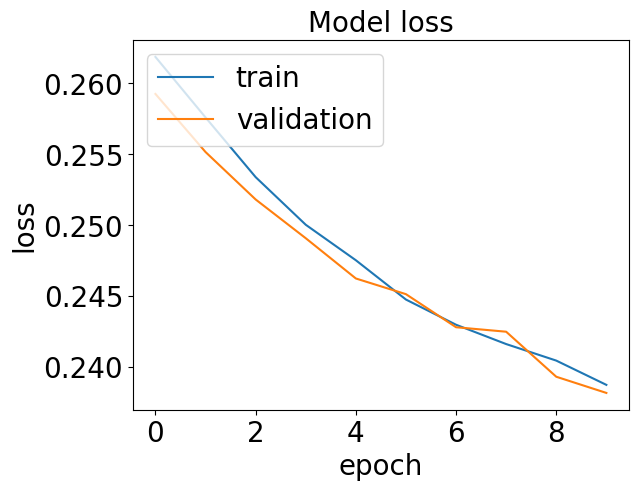

In [ ]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Adding title, y-label and x-label to the plot
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

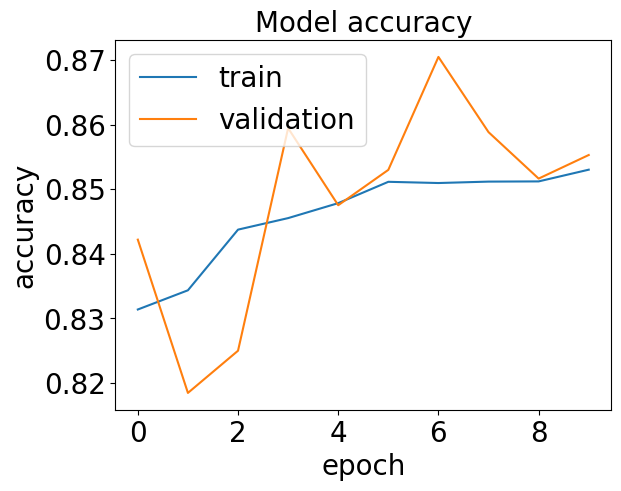

In [ ]:
# Plotting the training and validation accuracy
plt.plot(history.history['multi_label_acc'])
plt.plot(history.history['val_multi_label_acc'])

# Adding title, y-label and x-label to the plot
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

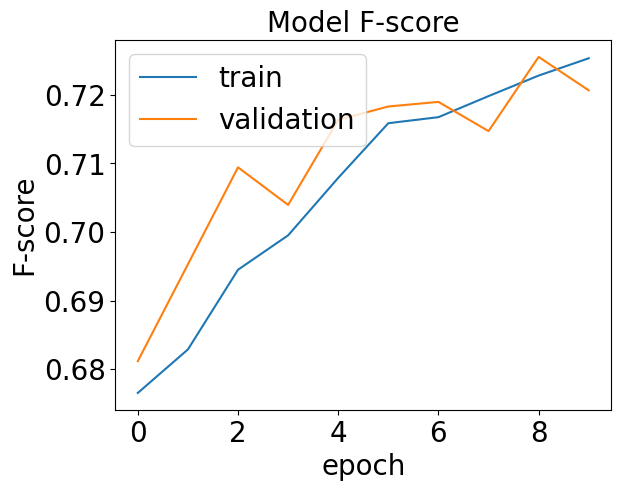

In [ ]:
# Plotting the training and validation F-scores
plt.plot(history.history['fbeta'])
plt.plot(history.history['val_fbeta'])

# Adding title, y-label and x-label to the plot
plt.title('Model F-score')
plt.ylabel('F-score')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()

From the eye test, this model performs just as good if not better than our custom CNN. For the test evaluation, I will be using this model and it's corresponding weights.

## Testing

The final step in the experiment is to use the best model to predict tags for the test images that were provided. First, we need to load the weights of the best model.

In [ ]:
model.load_weights(filepath=abspath_curr + 'result/model/pretrained_model_last_two.h5')

### Reading test files into an array

In [ ]:
X_test = []
submission = []

# loop through files in test image directory
for file in os.listdir(abspath_curr + 'data/test-jpg'):
  filename = file.split('.')[0]

  img = cv2.imread(abspath_curr + f'data/test-jpg/{filename}.jpg')
  targets = np.zeros(17)

  X_test.append(cv2.resize(img, (128, 128)))
  submission.append(filename)

Similar to the training array, we convert the test array into a numpy array and designate the value type. For the images, we normalize the pixel values by dividing by `255`.

In [ ]:
X_test = np.array(X_test, np.float16) / 255.

Time to make the predictions!

In [ ]:
y_test = model.predict(X_test, batch_size=16, verbose=2)

404/404 - 5s - 5s/epoch - 13ms/step


Generating the submission csv file. For each image, we only select labels that have a predicted value greater than `0.4`.

In [ ]:
import csv

with open(abspath_curr + 'result/final_submission.csv', 'w', newline='') as csvfile:
  csv_writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
  # add header
  csv_writer.writerow(('image_name', 'tags'))

  for i, image in enumerate(submission):
    tags = ' '.join(np.array(all_tags)[y_test[i] > 0.4])
    csv_writer.writerow((image, tags))

# Conclusion

This Kaggle challenge turned out to be quite the challenge (no pun intended). Processing and analyzing satellite imagery is integral to the function of monitoring deforestation and subsequently, fighting climate change. These images can be quite large and contain a lot of features, so it's important to create efficient pipelines and models that can confidently parse the data and provide insight.

Due to limitations in computation access and Google Drive, I was unable to use all the training data to train my models. This definitely affected the score of my models as I believe they would've improved had I not been bound by those limitations. Despite this, I was able to achieve a reasonably sensible score using a model that I created and the ResNet50 pretrained model.

For the pretrained model, the best results came when only the top 2 layers were unfrozen. This coincides with what we learned in class about transfer learning and it's benefits. Conducting this experiment has taught me a lot about working with imagery data and fine tuning CNN models. I wouldn't say I'm at point where I feel confident submitting my results to the competition, but I will continue to finetune my model architecture and extract better results.